# Import Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns



# Load the dataset

In [8]:
# change the path of the dataset
data = pd.read_csv('/home/lok/Documents/GroupProject/archive/wiki_movie_plots_deduped.csv')
data.head(5)

FileNotFoundError: [Errno 2] No such file or directory: '/home/lok/Documents/GroupProject/archive/wiki_movie_plots_deduped.csv'

In [ ]:
data.tail(5)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
34881,2014,The Water Diviner,Turkish,Director: Russell Crowe,Director: Russell Crowe\r\nCast: Russell Crowe...,unknown,https://en.wikipedia.org/wiki/The_Water_Diviner,"The film begins in 1919, just after World War ..."
34882,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,"Ahmet Kural, Murat Cemcir",comedy,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the..."
34883,2017,Olanlar Oldu,Turkish,Hakan Algül,"Ata Demirer, Tuvana Türkay, Ülkü Duru",comedy,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i..."
34884,2017,Non-Transferable,Turkish,Brendan Bradley,"YouTubers Shanna Malcolm, Shira Lazar, Sara Fl...",romantic comedy,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...
34885,2017,İstanbul Kırmızısı,Turkish,Ferzan Özpetek,"Halit Ergenç, Tuba Büyüküstün, Mehmet Günsür, ...",romantic,https://en.wikipedia.org/wiki/%C4%B0stanbul_K%...,The writer Orhan Şahin returns to İstanbul aft...


In [ ]:
data.shape

(34886, 8)

# Exploratory Data Analysis

In [ ]:
data.isnull().sum()

Release Year           0
Title                  0
Origin/Ethnicity       0
Director               0
Cast                1422
Genre                  0
Wiki Page              0
Plot                   0
dtype: int64

In [ ]:
data['Genre'].nunique()

2265

In [ ]:
data['Origin/Ethnicity'].nunique()

24

In [ ]:
data['Release Year'].nunique()

117

In [ ]:
data.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
34881    False
34882    False
34883    False
34884    False
34885    False
Length: 34886, dtype: bool

## Distribution of movies over the years

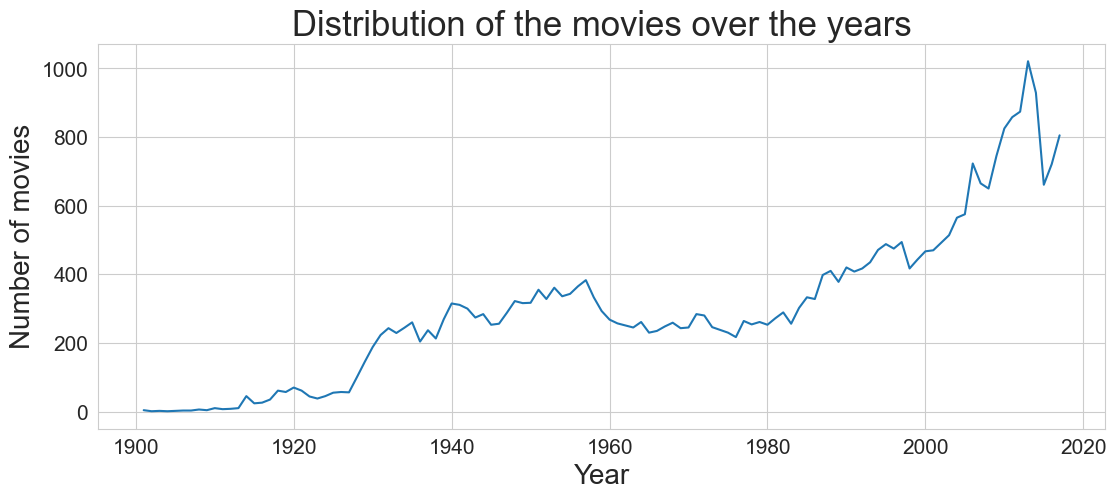

In [ ]:
import matplotlib.pyplot as plt

movies_per_year = data['Release Year'].value_counts().sort_index().reset_index()
movies_per_year.columns = ['Release Year' , 'Count']

sns.set_style('whitegrid')
plt.figure(figsize=(13, 5))

sns.lineplot(x='Release Year', y='Count', data=movies_per_year)

plt.title('Distribution of the movies over the years', fontsize=25)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Number of movies', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

## Movies origin

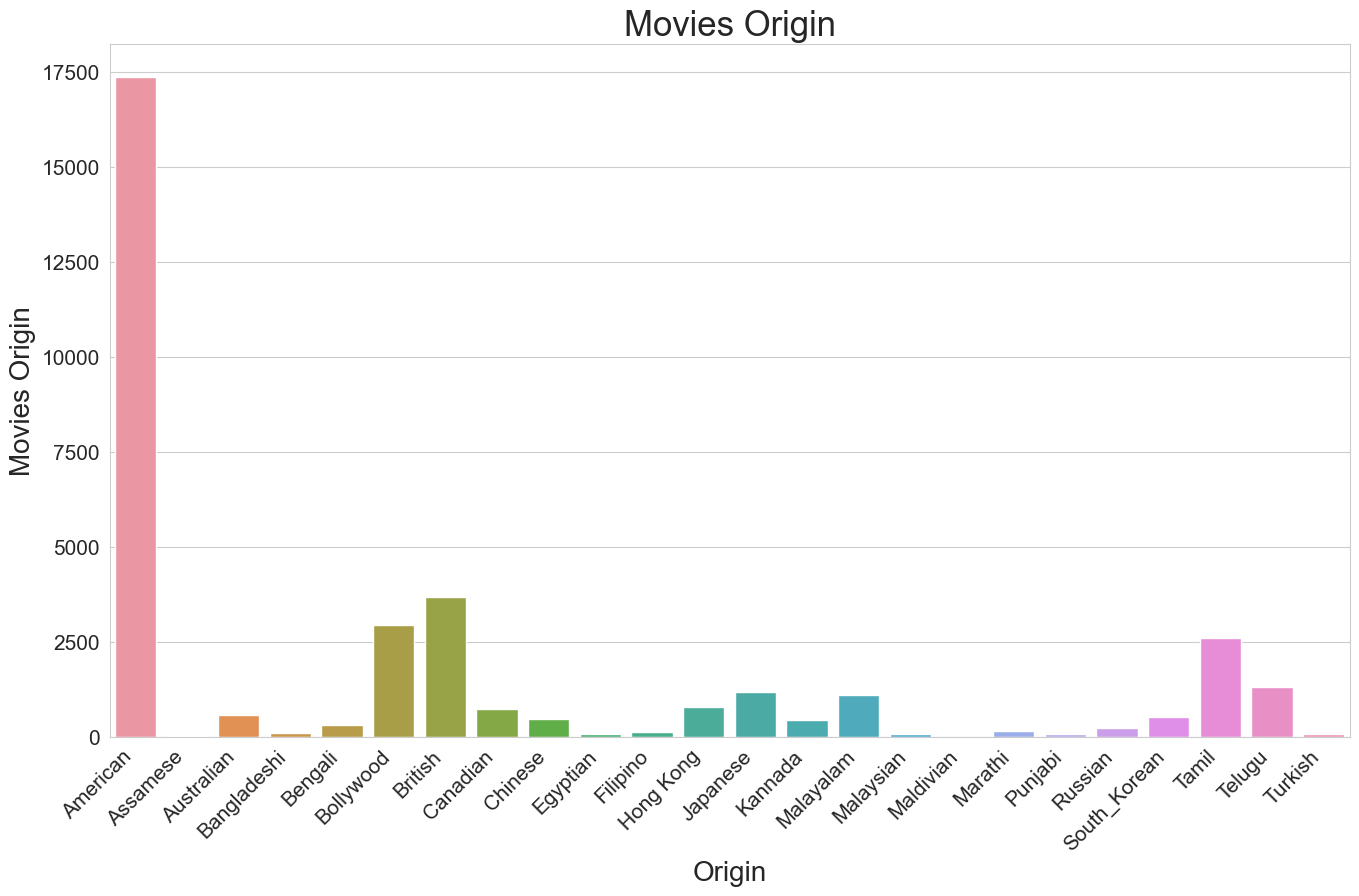

In [ ]:
movies_per_origin = data['Origin/Ethnicity'].value_counts().sort_index().reset_index()
movies_per_origin.columns = ['Origin', 'Count']


plt.figure(figsize=(16, 9))


sns.barplot(x='Origin', y='Count', data=movies_per_origin)

plt.title('Movies Origin', fontsize=25)
plt.xlabel('Origin', fontsize=20)
plt.ylabel('Movies Origin', fontsize=20)
plt.xticks(fontsize=15, rotation=45, ha='right')
plt.yticks(fontsize=15)

plt.show()


# Data Pre-processing

In [ ]:
# Import
import spacy
import string
import gensim
import operator
import re


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
def text_cleaner(text):
    
    # Remove any characters that are not uppercase letters, lowercase letters, or white space character.
    cleaned_text = re.sub(r'[^A-Za-z\s]', '', text) 
    
    # Replace conecutive spaces with a single space.
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text   

In [ ]:
# Create a list of stopwords
stop_words = set(stopwords.words('english'))

# Initialize limitizers
lemmatizer = WordNetLemmatizer()

In [ ]:
def text_tokenizer(text):
    
    # Remove any characters that are not uppercase letters, lowercase letters, or white space character.
    cleaned_text = re.sub(r'[^A-Za-z\s]', '', text) 
    
    # Replace conecutive spaces with a single space.
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    # Creating token objects      
    tokens = word_tokenize(cleaned_text)
    
    
    lowercase_tokens = [token.lower() for token in tokens]
    
    # remove stop words
    filtered_tokens = [token for token in lowercase_tokens if token not in stop_words]
    
    # limitize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    return lemmatized_tokens
    

In [ ]:
print("Cleaning and Tokenizing...")

%time data['plot_tokenized'] = data['Plot'].map(lambda x : text_tokenizer(x))

data.head(5)


Cleaning and Tokenizing...


NameError: name 'data' is not defined

NameError: name 'data' is not defined

In [ ]:
# store tokens separatly 
movie_tokenized = data['plot_tokenized']

In [ ]:
# Save the dataframe
data.to_csv('processed_movie_plot_data.csv', index=False)

# Building Word Dictionary

In [ ]:
from gensim import corpora

# Build a dictionary for the tokenizd words
%time dictionary = corpora.Dictionary(movie_tokenized)

NameError: name 'movie_tokenized' is not defined

In [ ]:
# Save the dictionary
dictionary.save('movie_dictionary')

In [ ]:
# Creating a list of lists
dict_tokens = [
    [
        [dictionary[key]
         , dictionary.token2id[dictionary[key]]]
        for key, value in dictionary.items()
        if key <= 50
    ]
]
# Printing the resulting list
print(dict_tokens)


[[['appear', 0], ['assault', 1], ['bar', 2], ['bartender', 3], ['beer', 4], ['begin', 5], ['breaking', 6], ['bucket', 7], ['burst', 8], ['carrie', 9], ['cash', 10], ['customer', 11], ['drink', 12], ['dumping', 13], ['everybody', 14], ['eye', 15], ['face', 16], ['fill', 17], ['fixture', 18], ['follower', 19], ['group', 20], ['hat', 21], ['head', 22], ['inside', 23], ['irish', 24], ['leave', 25], ['man', 26], ['mirror', 27], ['nation', 28], ['order', 29], ['policeman', 30], ['pulling', 31], ['register', 32], ['saloon', 33], ['seltzer', 34], ['serving', 35], ['smashing', 36], ['spray', 37], ['stereotypically', 38], ['water', 39], ['working', 40], ['wrecking', 41], ['bench', 42], ['better', 43], ['bigger', 44], ['blocked', 45], ['causing', 46], ['couple', 47], ['embrace', 48], ['everything', 49], ['fan', 50]]]


# Bag of Words

In [ ]:
%time corpus = [dictionary.doc2bow(desc) for desc in movie_tokenized] # Build bag of words for the tokens

CPU times: user 5.89 s, sys: 180 ms, total: 6.07 s
Wall time: 6.07 s


In [ ]:
word_frequencies = [[(dictionary[id], frequency) for id, frequency in line] for line in corpus[0:3]]

print(word_frequencies)

[[('appear', 1), ('assault', 1), ('bar', 1), ('bartender', 2), ('beer', 2), ('begin', 1), ('breaking', 1), ('bucket', 1), ('burst', 1), ('carrie', 1), ('cash', 1), ('customer', 1), ('drink', 1), ('dumping', 1), ('everybody', 1), ('eye', 1), ('face', 1), ('fill', 1), ('fixture', 1), ('follower', 1), ('group', 2), ('hat', 1), ('head', 1), ('inside', 1), ('irish', 2), ('leave', 1), ('man', 2), ('mirror', 1), ('nation', 2), ('order', 1), ('policeman', 1), ('pulling', 1), ('register', 1), ('saloon', 1), ('seltzer', 1), ('serving', 1), ('smashing', 1), ('spray', 1), ('stereotypically', 1), ('water', 1), ('working', 1), ('wrecking', 1)], [('face', 1), ('hat', 1), ('man', 1), ('bench', 1), ('better', 1), ('bigger', 1), ('blocked', 1), ('causing', 1), ('couple', 1), ('embrace', 1), ('everything', 1), ('fan', 1), ('fence', 1), ('frown', 1), ('get', 1), ('hang', 1), ('last', 1), ('learn', 1), ('left', 1), ('look', 1), ('moon', 5), ('night', 1), ('painted', 1), ('park', 1), ('past', 1), ('perched'

# Tf-Idf and LSI model

In [ ]:
movie_tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)

movie_lsi_model = gensim.models.LsiModel(movie_tfidf_model[corpus], id2word=dictionary, num_topics=400)



In [ ]:
# Save the models
movie_tfidf_model.save('movie_tfidf_model')
movie_lsi_model.save('movie_lsi_model')

In [ ]:
# Serialize the output of the model

gensim.corpora.MmCorpus.serialize('movie_tfidf_model_mm', movie_tfidf_model[corpus])

gensim.corpora.MmCorpus.serialize('movie_lsi_model_mm',movie_lsi_model[movie_tfidf_model[corpus]])

In [ ]:
# Load the previously serialized models back to memory.
# This allows you to use the preprocessed without having to remcompute it again.


movie_tfidf_corpus = gensim.corpora.MmCorpus('movie_tfidf_model_mm')
movie_lsi_corpus = gensim.corpora.MmCorpus('movie_lsi_model_mm')


In [ ]:
from gensim.similarities import MatrixSimilarity

"""
MatrixSimilarity: creates similarity index. This index allows efficient computation 
of cosine similarity between vectors in the LSI space.
Each row in the index matrix corresponds to a document (vector in the LSI space).
The entries of this matix are the norms of the documents.
"""

movie_index = MatrixSimilarity(movie_lsi_corpus, num_features=movie_lsi_corpus.num_terms)


In [ ]:
# Save similarity index
movie_index.save('movie_index')

# Search 

In [ ]:
from operator import itemgetter


def search(input_query):
    
    tokenized_input = text_tokenizer(input_query)
    bow_input = dictionary.doc2bow(tokenized_input)
    
    query_tfidf = movie_tfidf_model[bow_input]
    query_lsi = movie_lsi_model[query_tfidf]
    
    movie_index.num_best = 10
    
    movies_list = movie_index[query_lsi]
    
    
    movies_list.sort(key=itemgetter(1), reverse=True)
    movie_names = []
    
    for j, movie in enumerate(movies_list):

        movie_names.append (
            {
                'Relevance': round((movie[1] * 100),2),
                'Movie Title': data['Title'][movie[0]],
                'Movie Plot': data['Plot'][movie[0]],
                'Wikipedia Link' : data['Wiki Page'][movie[0]]
            }

        )
        if j == (movie_index.num_best-1):
            break

    return pd.DataFrame(movie_names, columns=['Relevance','Movie Title','Movie Plot', 'Wikipedia Link'])

In [ ]:
%time search('basketball')

CPU times: user 33.5 ms, sys: 0 ns, total: 33.5 ms
Wall time: 9.07 ms


,Relevance,Movie Title,Movie Plot,Wikipedia Link
0,73.29,Sunset Park,Phyllis Saroka (Perlman) is a P.E. teacher at ...,https://en.wikipedia.org/wiki/Sunset_Park_(film)
1,72.08,Glory Road,Newly appointed men's basketball coach Don Has...,https://en.wikipedia.org/wiki/Glory_Road_(film)
2,71.09,Slam Dunk: Shohoku's Greatest Challenge!,Hanamichi Sakuragi is a delinquent and the lea...,https://en.wikipedia.org/wiki/Slam_Dunk_(manga)
3,71.09,Slam Dunk: Howling Basketman Spirit!!,Hanamichi Sakuragi is a delinquent and the lea...,https://en.wikipedia.org/wiki/Slam_Dunk_(manga)
4,69.67,Above the Rim,Kyle Watson is a talented basketball player wh...,https://en.wikipedia.org/wiki/Above_the_Rim
5,69.05,The Comebacks,Coach Lambeau Fields (David Koechner) is pathe...,https://en.wikipedia.org/wiki/The_Comebacks
6,68.52,Rackety Rax,"Always looking for an angle, ""Knucks"" McGloin ...",https://en.wikipedia.org/wiki/Rackety_Rax
7,67.85,Inazuma Eleven: Saikyō Gundan Ōgre Shūrai,Endou Mamoru is a cheerful goalkeeper in Raimo...,https://en.wikipedia.org/wiki/Inazuma_Eleven_(...
8,67.44,Crossover,Noah Cruise is a naturally talented basketball...,https://en.wikipedia.org/wiki/Crossover_(2006_...
9,66.72,Going Vertical,1970 year. The Soviet national basketball team...,https://en.wikipedia.org/wiki/Going_Vertical
